---

# Análise VAMOS (VAMO3)

---

# **1) Instalando e Importando bibliotecas**

**Instalações**

In [ ]:
!pip install sidrapy
!pip install investpy
!pip install plotly
!pip install nasdaq-data-link
!pip install yfinance

**Importações**

In [ ]:
import requests
import sidrapy
import pandas as pd
import investpy
import plotly.graph_objects as go
import plotly.subplots
import pandas as pd
import io
import yfinance as yf

from plotly.subplots import make_subplots

**Importando e onectando à API Nasdaq**

In [ ]:
import nasdaqdatalink
nasdaqdatalink.read_key(filename="chave_API_NasdaqDL.txt")

**Link gerado pela API SIDRA para coleta dos dado do IBGE:**
https://sidra.ibge.gov.br/tabela/1620


- `https://apisidra.ibge.gov.br/values/t/1620/n1/all/v/all/p/all/c11255/90707/d/v583%202`

- t (table_code) = 1620
- n (territorial_level) = 1
- n/ (ibge_territorial_code) = all
- v (variable) = all
- p (period) = all
- c/ (categories) = 11255/90707

<br>

---

<br>

# **2) Coletando dados Macroeconômicos**

###PIB:

- **Impacto:** Um PIB em expansão normalmente significa um aumento na demanda por caminhões para transportar mercadorias, o que pode impulsionar os negócios da empresa. Por outro lado, um PIB em desaceleração ou recessão pode reduzir a demanda por serviços de locação de caminhões.

In [ ]:
# Importa os dados do SIDRA
pib_sa_raw = sidrapy.get_table(table_code= "1621",
                            territorial_level = "1",
                            ibge_territorial_code = "all",
                            period = "all",
                            classification = "11255/90707")

In [ ]:
# Checamos a importação
pib_sa_raw.head(3)

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N,D4C,D4N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Trimestre (Código),Trimestre,Setores e subsetores (Código),Setores e subsetores,Variável (Código),Variável
1,1,Brasil,30,Número-índice,99.41,1,Brasil,199601,1º trimestre 1996,90707,PIB a preços de mercado,584,Série encadeada do índice de volume trimestral...
2,1,Brasil,30,Número-índice,100.65,1,Brasil,199602,2º trimestre 1996,90707,PIB a preços de mercado,584,Série encadeada do índice de volume trimestral...


- `table_code`: Este é o código da tabela específica de dados que você deseja importar. No código fornecido, "1621" parece ser o código da tabela que contém os dados do PIB (Produto Interno Bruto).

- `territorial_level`: Este argumento especifica o nível territorial dos dados. "1" geralmente se refere ao nível nacional (Brasil).

- `ibge_territorial_code`: Aqui, "all" indica que você deseja importar dados para todas as subdivisões territoriais disponíveis (por exemplo, estados, municípios) dentro do nível territorial especificado.

- `period`: "all" indica que você deseja importar dados para todos os períodos disponíveis, o que significa que você está buscando dados de PIB ao longo do tempo.

- `classification`: Este argumento parece ser usado para especificar a classificação específica dos dados que você deseja. "11255/90707" pode se referir a categorias específicas relacionadas ao PIB, mas sem informações adicionais, não posso dar uma explicação exata.

---

<br>

**Alterando os nomes das colunas de interesse e remover o restante das colunas.**

In [ ]:
# Substitui as colunas pela primeira observação
pib_sa_raw.columns = pib_sa_raw.iloc[0]

# Retira a primeira observação
pib_sa_raw = pib_sa_raw.iloc[1:, :]

# Altera para float a coluna do valor
pib_sa_raw['Valor'] = pib_sa_raw['Valor'].astype(float)

In [ ]:
# Renomeia e seleciona as colunas de interesse
pib_sa = pib_sa_raw.rename(columns = {"Valor" : "pib_sa",
                                "Trimestre (Código)" : "date"})[['pib_sa', 'date']]

---

<br>

**Removemos da coluna o valor numérico referente ao trimestre e alteramos para um valor que se aproxime de um mês relacionado em período de trimestres.**

In [ ]:
# Lidar com a coluna de trimestre para transformar em data
pib_sa['date'] = pib_sa['date'].str[:-2] + pib_sa['date'].str[-2:].replace({"01" : "03",
                                                                  "02" : "06",
                                                                  "03" : "09",
                                                                  "04" : "12"})

---

<br>

**Por fim, utilizamos a função to_datetime() para transformar em formato de data e inserir dentro do índice.**

In [ ]:
# Transforma em formato date a coluna de data e insere no índice
pib_sa.index = pd.to_datetime(pib_sa['date'],format = "%Y%m")

# Retira a coluna de data
pib_sa = pib_sa.drop(columns = ['date'])

---

<br>

**Visulizando**

- **Impacto:** Um PIB em expansão normalmente significa um aumento na demanda por caminhões para transportar mercadorias, o que pode impulsionar os negócios da empresa

  Por outro lado, um PIB em desaceleração ou recessão pode reduzir a demanda por serviços de locação de caminhões.

In [ ]:
pib_sa

,pib_sa
date,
1996-03-01,99.41
1996-06-01,100.65
1996-09-01,104.15
1996-12-01,103.38
1997-03-01,104.41
...,...
2022-06-01,178.56
2022-09-01,179.36
2022-12-01,179.52


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pib_sa.index, y=pib_sa['pib_sa']))
fig.update_layout(title_text= 'Crescimento do PIB')
fig.show()

---

<br>

### Taxas de Juros (Taxa SELIC):

- **Impacto:** Taxas de juros mais baixas podem reduzir os custos financeiros da empresa, tornando mais acessível o financiamento para a compra de frota.

  Por outro lado, taxas de juros mais altas podem aumentar os custos operacionais, impactando a margem de lucro da empresa.

In [ ]:
selic = nasdaqdatalink.get('bcb/4189', start_date = '2000-01-01')
selic.rename(columns = {'Value': 'Selic'}, inplace = True)
selic

,Selic
Date,
2000-01-31,18.94
2000-02-29,18.87
2000-03-31,18.85
2000-04-30,18.62
2000-05-31,18.51
...,...
2023-05-31,13.65
2023-06-30,13.65
2023-07-31,13.65


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=selic.index, y=selic['Selic']))
fig.update_layout(title_text = 'Selic Mensal')
fig.show()

---

<br>

### Índice de Confiança do Empresário Industrial e Índice de confiança do Consumidor:

- **Impacto**: Quando os empresários estão otimistas, eles tendem a investir mais em seus negócios, o que pode aumentar a demanda por caminhões para atender a essa crescente atividade econômica.

  Portanto, um alto índice de confiança empresarial pode ser um indicador positivo para a empresa. Por outro lado, uma queda na confiança empresarial pode levar a uma redução na demanda.

- **Índice de Confiança do Empresário Industrial:**

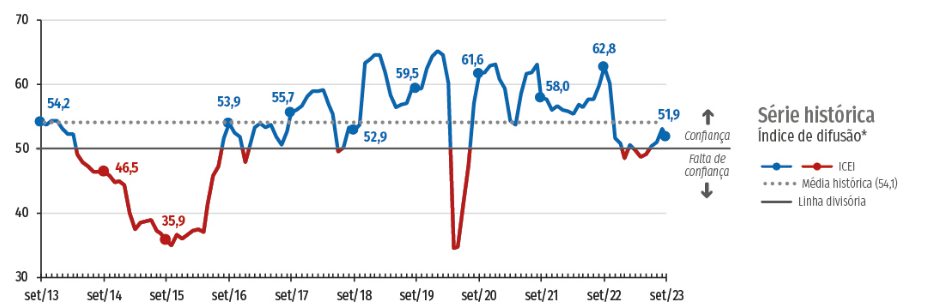

- **Índice de confiança do Consumidor:**

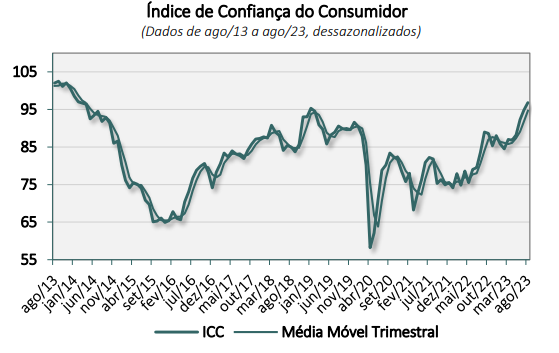


---

<br>

###IPCA:

- O IPCA é um dos principais índices de inflação no Brasil. Ele é calculado pelo Instituto Brasileiro de Geografia e Estatística (IBGE) e tem como objetivo medir a variação dos preços de uma cesta de produtos e serviços consumidos pela população brasileira.



In [ ]:
ipca = nasdaqdatalink.get('BCB/13522', start_date = '2021-02-02')
ipca.rename(columns={'Value':'IPCA'}, inplace = True)

In [ ]:
ipca.head()

,IPCA
Date,
2021-02-28,5.20
2021-03-31,6.10
2021-04-30,6.76
2021-05-31,8.06
2021-06-30,8.35


In [ ]:
fig = go.Figure() # Criando objeto/figura
fig.add_trace(go.Scatter(x=ipca.index, y=ipca['IPCA'])) # Adicionando um gráfico ao objeto/figura
fig.update_layout(title_text = 'IPCA') # Colocando título no gráfico
fig.show() # Exibindo o gráfico

# **3) Coletando preços das ações da Vamos**

## VAMO3 vs IPCA

In [ ]:
vamos = yf.download('VAMO3.SA', start = '2021-02-02')['Adj Close']
vamos3 = pd.DataFrame(vamos)
vamos3.rename(columns={'Adj Close':'Preço'}, inplace = True)
vamos3

[*********************100%%**********************]  1 of 1 completed


,Preço
Date,
2021-02-02,7.702902
2021-02-03,7.773789
2021-02-04,7.750159
2021-02-05,7.679275
2021-02-08,8.116402
...,...
2023-09-12,11.130000
2023-09-13,11.070000
2023-09-14,11.220000


In [ ]:
fig = make_subplots(specs = [[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=ipca.index, y=ipca['IPCA'], name = 'IPCA'), secondary_y = False)
fig.add_trace(go.Scatter(x=vamos3.index, y=vamos3['Preço'], name='Preço VAMO3'), secondary_y = 'True')
fig.update_layout(title_text='VAMO3 vc IPCA')
fig.show()

## Janela de volatilidade

In [ ]:
vamos_retornos = vamos3['Preço'].pct_change()
rol_vol = vamos_retornos.rolling(30).std()

fig = go.Figure()
fig.add_trace(go.Scatter(x=rol_vol.index, y=rol_vol))
fig.update_layout(title_text='Janela de volatilidade 30 dias VAMO3')
fig.show()

<br>

---

<br>

# **4) Importando arquivo XLSX de resultados da VAMO3**

In [ ]:
indicadores = pd.read_excel('VAMO3.DFs (6).xlsx')

In [ ]:
indicadores.set_index('Vamos (R$ milhões) - DRE', inplace = True)
indicadores.head(3)

,1Q16,2Q16,3Q16,4Q16,1Q17,2Q17,3Q17,4Q17,1Q18,2Q18,...,2019,2019.1,2020,2021,2022,2023,1S22,1S23,Var % 2T23/2T22,Var % 1S23/1S22
Vamos (R$ milhões) - DRE,,,,,,,,,,,,,,,,,,,,,
CONSOLIDADO GRUPO VAMOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Receita Bruta,159.309364,173.392528,188.484746,202.886418,180.077641,193.962192,200.852782,187.157638,247.018954,262.231613,...,1321.741149,1321.741149,1661.632114,3095.609713,5439.345259,3591.043442,2350.064154,3591.043442,0.299175,0.528062
Receita Bruta com a prestação de serviços,149.03842,155.513955,169.799673,172.585673,159.885809,180.226304,180.016016,173.402466,226.520902,245.209128,...,1108.38991,1108.389910,1485.429342,2957.214607,5107.479702,3166.785513,2238.827045,3166.785513,0.228058,0.414484


In [ ]:
# indicadores.set_index('Vamos (R$ milhões) - DRE', inplace = True)

In [ ]:
indicadores

,1Q16,2Q16,3Q16,4Q16,1Q17,2Q17,3Q17,4Q17,1Q18,2Q18,...,2019,2019.1,2020,2021,2022,2023,1S22,1S23,Var % 2T23/2T22,Var % 1S23/1S22
Vamos (R$ milhões) - DRE,,,,,,,,,,,,,,,,,,,,,
CONSOLIDADO GRUPO VAMOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Receita Bruta,159.309364,173.392528,188.484746,202.886418,180.077641,193.962192,200.852782,187.157638,247.018954,262.231613,...,1321.741149,1321.741149,1661.632114,3095.609713,5439.345259,3591.043442,2350.064154,3591.043442,0.299175,0.528062
Receita Bruta com a prestação de serviços,149.03842,155.513955,169.799673,172.585673,159.885809,180.226304,180.016016,173.402466,226.520902,245.209128,...,1108.38991,1108.389910,1485.429342,2957.214607,5107.479702,3166.785513,2238.827045,3166.785513,0.228058,0.414484
Receita Bruta com a venda de ativos,10.270944,17.878573,18.685073,30.300745,20.191832,13.735887,20.836766,13.755172,20.498052,17.022485,...,213.351239,213.351239,176.202772,138.395106,331.865557,424.257929,111.237109,424.257929,1.678624,2.813996
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alavancagem Líquida,NaN,NaN,NaN,NaN,-,-,-,2.151469,1.857099,2.377839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Recortando as colunas trimestrais**

In [ ]:
import re

# Lista original de colunas
colunas_originais = ['1Q16', '2Q16', '3Q16', '4Q16', '1Q17', '2Q17', '3Q17', '4Q17', '1Q18', '2Q18', '3Q18', '4Q18', '1Q19', '2Q19', '3Q19', '4Q19', '1Q19.1', '2Q19.1', '3Q19.1', '4Q19.1', '1Q20', '2Q20', '3Q20', '4Q20', '1Q21', '2Q21', '3Q21', '4Q21', '1Q22', '2Q22', '3Q22', '4Q22', '1Q23', '2Q23', 2016, 2017, 2018, 2019, '2019.1', 2020, 2021, 2022, 2023, '1S22', '1S23', 'Var % 2T23/2T22', 'Var % 1S23/1S22']

# Expressão regular para identificar o formato '1Q16', '2Q16', etc.
padrao_trimestral = r'\dQ\d{2}'

# Lista de colunas no formato trimestral
colunas_trimestrais = [coluna for coluna in colunas_originais if re.match(padrao_trimestral, str(coluna))]

# Exibir a lista resultante
print(colunas_trimestrais)

['1Q16', '2Q16', '3Q16', '4Q16', '1Q17', '2Q17', '3Q17', '4Q17', '1Q18', '2Q18', '3Q18', '4Q18', '1Q19', '2Q19', '3Q19', '4Q19', '1Q19.1', '2Q19.1', '3Q19.1', '4Q19.1', '1Q20', '2Q20', '3Q20', '4Q20', '1Q21', '2Q21', '3Q21', '4Q21', '1Q22', '2Q22', '3Q22', '4Q22', '1Q23', '2Q23']


In [ ]:
indicadores.drop(columns = ['1Q19.1', '2Q19.1', '3Q19.1', '4Q19.1',2016, 2017, 2018, 2019, '2019.1', 2020, 2021, 2022, 2023, '1S22', '1S23', 'Var % 2T23/2T22', 'Var % 1S23/1S22'], inplace = True)

<br>

---

<br>

# **5) Análisando Métricas DRE**


<br>


## **Consolidado:**

## Avaliando o Receita Líquida Consolidada vs Lucro Líquido Consolidado

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Receita Líquida_Cons.'],name='Receita Líquida_Cons.', text=indicadores.loc['Receita Líquida_Cons.']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Receita Líquida Consolidada (R$ Milhões)')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Receita Líquida_Cons.'], name = 'Receita Líquida'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Lucro Líquido do Exercício_Cons.'], name = 'Lucro Líquido'))
fig.update_layout(title_text = 'Receitas vs Lucro')
fig.show()

## Avaliando o EBIT vs EBITDA Consolidado

In [ ]:
indicadores.loc['EBIT_Cons.'] = indicadores.loc['EBIT_Cons.'].astype(float)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=indicadores.columns, y=indicadores.loc['EBIT_Cons.'], name = 'EBIT Consolidado'))
fig.add_trace(go.Scatter(x=indicadores.columns, y=indicadores.loc['EBITDA_Cons.'], name = 'EBITDA Consolidado'))
fig.update_layout(title_text = 'EBIT vs EBITDA')
fig.show()

## Avaliando o Resultado Financeiro Consolidado

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Receitas Financeiras_Cons.'], name = 'Receitas Financeiras'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Despesa Financeiras_Cons.'], name = 'Despesa Financeiras'))
fig.update_layout(title_text = 'Receitas Financeiras vs Despesa Financeiras ')
fig.show()

## Avaliando o Lucro Líquido Consolidado

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Lucro Líquido do Exercício_Cons.'],name='Lucro Líquido Consolidado', text=indicadores.loc['Lucro Líquido do Exercício_Cons.']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Lucro Líquido Consolidado (R$ Milhões)')
fig.show()

<br>

---

<br>

# **5.1) Avaliação por linha de negócio:**

- **1.** Locações;
- **2.** Concessionárias;
- **3.** Customização;

## Receita Líquida por linha de negócio:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Receita Líquida_Locações'], name = 'Locações'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['Receita Líquida_Concessionárias'], name = 'Concessionárias'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['Receita Líquida_Customização'], name = 'Customização'))
fig.update_layout(title_text='Receitas por linha de negócio')
fig.show()

## Custos por linha de negócio:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Custo_Locações'], name = 'Locações'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['Custo_Concessionárias'], name = 'Concessionárias'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['Custo_Customização'], name = 'Customização'))
fig.update_layout(title_text='Custos por linha de negócio')
fig.show()

## EBITDA por linha de negócio:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['EBITDA_Locações'], name = 'Locações'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['EBITDA_Concessionárias'], name = 'Concessionárias'))
fig.add_trace(go.Bar(x=indicadores.columns, y= indicadores.loc['EBITDA_Customização'], name = 'Customização'))
fig.update_layout(title_text='EBITDA por linha de negócio')
fig.show()

<br>

---

<br>

# **6) Análisando Métricas Balanço Patrimonial**


## Ativo Circulante vs Passivo Circulante:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Total do ativo circulante_BP'], name = 'Ativo Circulante'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Total do passivo circulante_BP'], name = 'Passivo Circulante'))
fig.update_layout(title_text = 'Ativo Circulante vs Passivo Circulante')
fig.show()

## Ativo Não Circulante vs Passivo Não Circulante:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Total do ativo não circulante_BP'], name = 'Ativo Circulante'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Total do passivo não circulante_BP'], name = 'Passivo Circulante'))
fig.update_layout(title_text = 'Ativo Não Circulante vs Passivo Não Circulante')
fig.show()

## Composição do Patrimônio Líquido:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Capital social_BP'], name = 'Capital Social'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Reservas de capital_BP'], name = 'Reservas de Capital'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Ações em tesouraria_BP'], name = 'Ações em Tesouraria'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Reservas de lucros _BP'], name = 'Reservas de Lucros'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Lucro do exercício_BP'], name = 'Lucro do Exercício'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Participação acionista não controlador_BP'], name = 'Participação acionista não controlador'))
fig.update_layout(title_text = 'Patrimônio Líquido VAMOS')
fig.show()

## Endividamento:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Dívida Bruta Total'], name = 'Dívida'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Caixa Total'], name = 'Caixa'))
fig.update_layout(title_text = 'Dívida Bruta Total vs Caixa Total')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Dívida Líquida'], name = 'Dívida', text=indicadores.loc['Dívida Líquida']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'Dívida Líquida')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Alavancagem Líquida'], name = 'Alavancagem Líquida', text=indicadores.loc['Alavancagem Líquida']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'Alavancagem Líquida')
fig.show()

<br>

---

<br>

# **7) Análisando Métricas dos Dados Operacionais e Financeiros**

In [ ]:
indicadores = pd.read_excel('VAMO3.DFs (6).xlsx', sheet_name=1)

indicadores.set_index('Vamos - Dados Operacionais', inplace = True)
indicadores.head(3)

,2017,1Q18,2Q18,3Q18,4Q18,2018,1Q19,2Q19,3Q19,4Q19,...,4Q21,2021,1Q22,2Q22,3Q22,4Q22,2022,1Q23,2Q23,2023
Vamos - Dados Operacionais,,,,,,,,,,,,,,,,,,,,,
Número de ativos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Início do período,6504.0,9117.0,9393.0,9802.0,10916.0,9117.0,10862.0,11326.0,12847.0,13060.0,...,20384.0,15128.0,23627.0,26859.0,33940.0,38561.0,23627.0,43829.0,45055.0,43829.0
Transferência de ativos,540.0,NaN,NaN,240.0,NaN,240.0,NaN,159.0,34.0,75.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,168.0,168.0


In [ ]:
indicadores.drop(columns=[2017,2018,2019, 2020,2021, 2022, 2023], axis = 1, inplace = True)

In [ ]:
indicadores.columns

Index(['1Q18', '2Q18', '3Q18', '4Q18', '1Q19', '2Q19', '3Q19', '4Q19', '1Q20',
       '2Q20', '3Q20', '4Q20', '1Q21', '2Q21', '3Q21', '4Q21', '1Q22', '2Q22',
       '3Q22', '4Q22', '1Q23', '2Q23'],
      dtype='object')

## Total de Ativos (Máquinas e Caminhões):

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Total'], name = 'Total de Ativos', text=indicadores.loc['Total']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'Total de Ativos (Máquinas e Caminhões)')
fig.show()

In [ ]:
indicadores = pd.read_excel('VAMO3.DFs (6).xlsx', sheet_name=2)

indicadores.set_index('Vamos - Dados Operacionais e Financeiros', inplace = True)
indicadores.head(3)

,1Q21,2Q21,3Q21,4Q21,2021,1Q22,2Q22,3Q22,4Q22,2022,1Q23,2Q23,2023,Var % A/A,Var % Q/Q,Var % S/S
Vamos - Dados Operacionais e Financeiros,,,,,,,,,,,,,,,,
(R$ milhões),1T21,2T21,3T21,4T21,2021.0,1T22,2T22,3T22,4T22,2022.0,1T23,2T23,2023,Var % A/A,Var % T/T,Var % S/S
CAPEX Implantado,483.7,527.8,561.6,506.6,2079.7,846,1160.2,1362.8,1476,4845.0,1315.8,1048.4,2364.2,-0.096363,-0.203222,0.178447
Backlog (Receita Futura Contratada),4189.7,5119.6,6180.8,6935.4,6935.4,8864.9,10794.3,12589.7,13725.8,13725.8,15678.5,16207.3,16207.3,0.501468,0.033728,NaN


In [ ]:
indicadores.drop(columns=[2021,2022,2023, 'Var % A/A','Var % Q/Q','Var % S/S'], axis = 1, inplace = True)

## CAPEX Implantado na Operação:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['CAPEX Implantado'], name = 'CAPEX Implantado', text=indicadores.loc['CAPEX Implantado']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'CAPEX Implantado na Operação')
fig.show()

## Backlog (Receita Futura Contratada):

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Backlog (Receita Futura Contratada)'], name = 'Backlog', text=indicadores.loc['Backlog (Receita Futura Contratada)']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'Backlog (Receita Futura Contratada)')
fig.show()

## Estoque total:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['Estoque total'], name = 'Estoque de ativos', text=indicadores.loc['Estoque total']))
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text = 'Estoque de ativos novos de locação')
fig.show()

## ROE e ROIC:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['ROIC'], name = 'ROIC'))
fig.add_trace(go.Bar(x=indicadores.columns, y=indicadores.loc['ROE'], name = 'ROE'))
fig.update_layout(title_text = 'ROIC vs ROE')
fig.show()